<a href="https://colab.research.google.com/github/jasreman8/Data_Scientist_Employee_Attrition_Project/blob/main/Prompt_Engineering_for_LLM_Automation_Classification_%26_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Context

Large Language Models (LLMs) offer significant business value in tasks like classification and text generation by enabling automation at scale.

This project will explore applying prompt engineering techniques for two such applications - Text Classification, and Text Generation (Summarization) and methods to evalute the LLM outputs.

In text classification, LLMs can analyze customer feedback, emails, or support tickets to categorize sentiment, intent, or urgency—helping companies streamline operations, reduce costs and prioritize responses.

LLMs can also assist in various text generation tasks such as:
- creating personalized marketing content,
- automated report writing etc.

driving efficiency and enhancing user experience.

# Objective

The business objective in this notebook focuses on two case studies to demonstrate how Large Language Models (LLMs) can be leveraged to automate and optimize key knowledge-intensive workflows.

In the first scenario—**Support Ticket Classification**—LLMs are employed to automatically categorize incoming support tickets based on their content, enabling faster routing, improved response times, and reduced manual overhead for customer support teams.

In the second scenario—**Summarization of Legal Documents**—LLMs are used to generate concise and accurate summaries of lengthy legal texts, helping legal professionals quickly grasp key information, reduce time spent on document review, and enhance productivity.

Together, these use cases illustrate how LLMs can drive operational efficiency and decision-making in both customer service and legal domains.

# Installing and Importing the Necessary Libraries

In this section, we first install and import the following libraries required to run the notebook.

- The  `OpenAI` library can be used to instantiate a Python client for interacting with OpenAI's APIs, including GPT models.
- `datasets` is a Hugging Face library for accessing and managing large-scale datasets, commonly used in NLP tasks.
- `evaluate` is a Hugging Face library used to compute evaluation metrics (e.g., accuracy, F1-score, BLEU) for machine learning models.
- The `bert-score` python library is useful for evaluating text generation models using BERT embeddings to measure semantic similarity between predicted and reference texts.



# Installing the required libraries
!pip install -q openai==1.66.3  \
                datasets==3.3.2 \
                evaluate==0.4.3 \
                bert-score==0.3.13

Importing the Libraries

In [1]:
# Import the built-in json module to work with JSON data
import json

# Import numpy for numerical operations and array handling
import numpy as np

# Import the OpenAI Python SDK to interact with OpenAI's API
from openai import OpenAI

# Import Hugging Face's function to load pre-built or custom datasets
from datasets import load_dataset

# Import tqdm to provide a progress bar for loops
from tqdm import tqdm

# Import HuggingFace's evaluate module for accessing standard evaluation metrics
from evaluate import load

# Import F1 score function from scikit-learn for classification performance evaluation
from sklearn.metrics import f1_score

Instantiating OpenAI API Key via Colab Secrets

In [2]:
# Accessing environment variables via Colab Secrets
from google.colab import userdata

# Set the OpenAI key in Colab Secrets
openai_api_key = userdata.get('my_api_key')

HF_TOKEN = userdata.get('hugging_face_token')

# Refer to the content page present at the top of module for accessing the Open AI API_KEY from Olympus platform
# The following code sets up the OpenAI client instance with the API Key and the API Endpoint
client = OpenAI(
    api_key = openai_api_key,
)

# GPT-4o-mini will be the primary model used in this notebook
model_name = 'gpt-4o-mini'

Effective prompt engineering involves a series of iterations to craft the best version for a given task-it involves starting simple and iteratively refining the prompt based on the output response quality.

In a **zero-shot** setting, the model is given only the task description without any examples (e.g., "Classify the following support ticket as Billing, Technical, or General:").

If the output is inaccurate or inconsistent, the prompt can be improved by adding structure or clarity, such as specifying formatting instructions or expected labels.

If the output is still not optimal, move to **few-shot** prompting, where examples are added to guide the model's behavior.

Through iterative refinement, prompts are optimized by adjusting language, tone, context, or examples to align better with task goals and evaluation metrics—ultimately improving consistency, accuracy, and reliability of the LLM output.


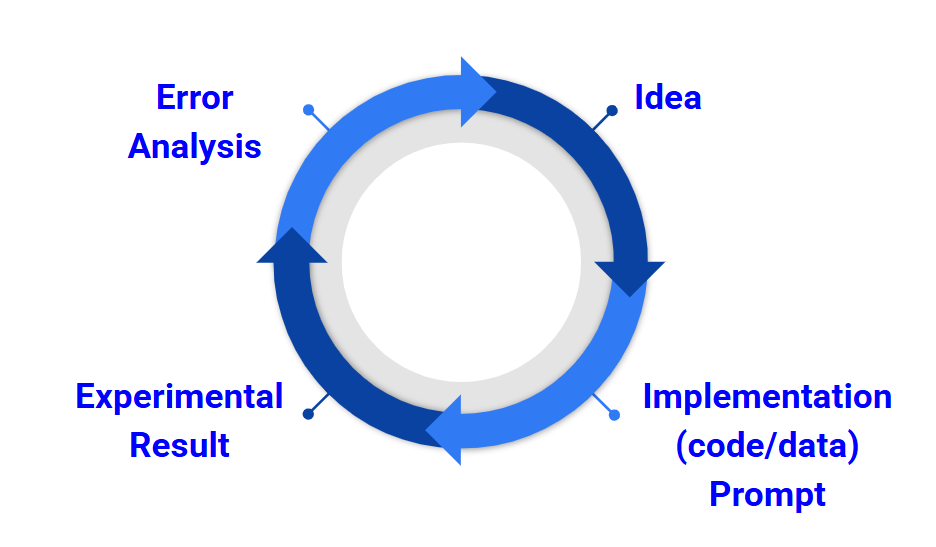

# Case Study 1

**Business Scenario: Support Ticket Classification Using LLMs**


Large Language Model (LLMs) can be used to enhance the efficiency of the ticket management process, reduce response times for urgent incidents, and optimize resource allocation.


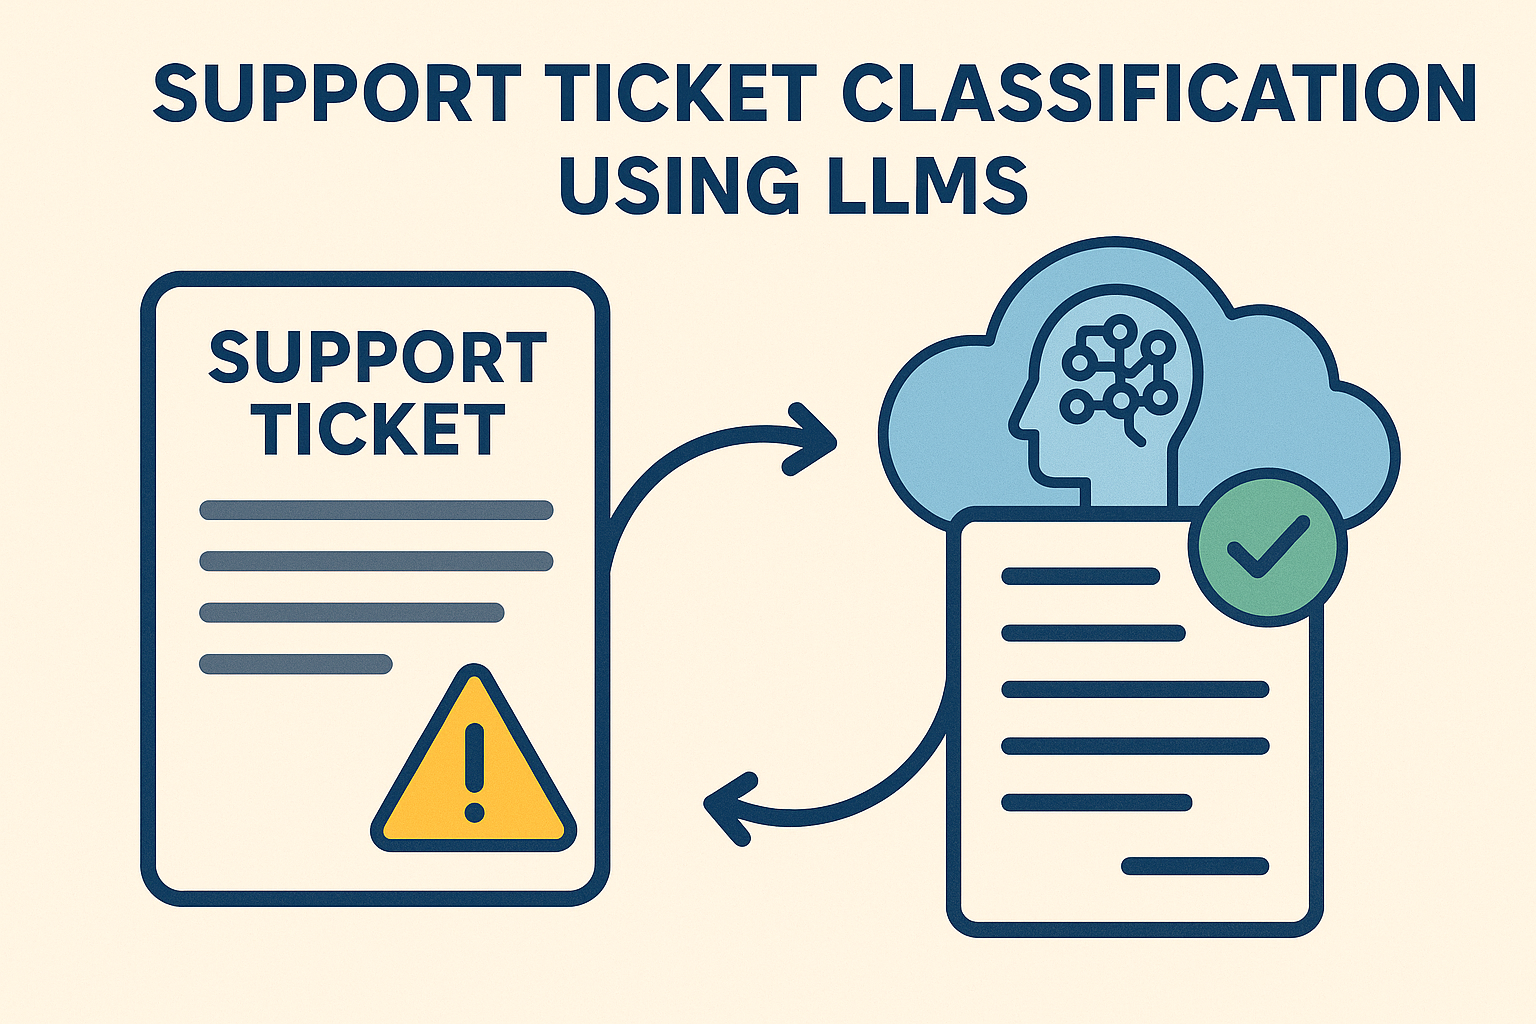


Using LLMs for categorization, incoming tickets will be automatically classified into four key categories:
 - **Incident** (urgent disruptions)
 - **Request** (standard inquiries)
 - **Problem** (systemic root causes)
 - **Change** (planned modifications)

This automated classification is expected to enable faster and more accurate ticket sorting, thereby improving overall service delivery and operational effectiveness.

The dataset `support-message-categorization` contains two splits - `examples` and `gold_examples` each containing 64 entries containing various support messages from 4 different categories, with the dataset containing columns `customer_message` and `type` denoting the support message and the support category respectively.

The following code loads the dataset from HuggingFace using the `load_dataset` method.

In [3]:
# Load the dataset for support messages from the provided repo
support_ticket_categories = load_dataset("kaustuvkunal/support-message-categorization")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# Load the examples and gold examples from the original dataset and convert them to pandas dataframe
support_ticket_categories_examples_df = support_ticket_categories['examples'].to_pandas()
support_ticket_categories_gold_examples_df = support_ticket_categories['gold_examples'].to_pandas()

In [5]:
# Shape of the examples
support_ticket_categories_examples_df.shape

(64, 2)

In [6]:
# Shape of the gold examples
support_ticket_categories_gold_examples_df.shape

(64, 2)

In [7]:
# Let's look at the first four samples in the examples dataframe
support_ticket_categories_examples_df.sample(4)

customer_message     type
8   Could you provide more details on the invoice ...  Request
45  The marketing agency is encountering billing d...  Problem
3   Could you provide more detailed information ab...  Request
61  I am writing to request an update to the billi...   Change

In [8]:
# # Let's look at the first four samples in the gold examples dataframe
support_ticket_categories_gold_examples_df.sample(4)

customer_message     type
40  Our company has encountered unanticipated bill...  Problem
15  Could you kindly inform me about the payment o...  Request
9   Dear Customer Support, I am contacting you to ...  Request
44  Facing issues with billing discrepancies on Sm...  Problem

In the following code, a naive zero-shot technique will be used to perform classification on the support tickets.

**Assembling and evaluating prompts**

## Zero-shot Prompt

Let us assemble a naive zero-shot prompt and evaluate it.

The following zero-shot system message mentions briefly the categories into which the support messages need to be classified  - incident, request, problem, change.

In [9]:
# support categorization system prompt v1
zero_shot_system_message_v1 = """
Classify customer support messages into one of these categories:
1) Incident: Unexpected issue requiring immediate attention
2) Request: Routine inquiry or service request
3) Problem: Underlying issue causing multiple incidents
4) Change: Planned change or update
"""

In [10]:
zero_shot_prompt_v1 = [{'role': 'developer', 'content': zero_shot_system_message_v1}]

In [11]:
zero_shot_prompt_v1

[{'role': 'developer',
  'content': '\nClassify customer support messages into one of these categories:\n1) Incident: Unexpected issue requiring immediate attention\n2) Request: Routine inquiry or service request\n3) Problem: Underlying issue causing multiple incidents\n4) Change: Planned change or update\n'}]

To evaluate this prompt—and all subsequent iterations—we define a scoring function that calculates the **F1-Score** based on a set of gold examples.

The F1-Score, which is the **harmonic mean of precision and recall**, serves as a balanced metric for assessing classification performance.

- Precision measures how many of the predicted positive labels are actually correct.

- Recall measures how many of the actual positive labels were correctly predicted.



\begin{align}
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
\end{align}

The F1 score ranges from 0 to 1:

- 1 indicates perfect precision and recall — the model predicted all correct labels and didn’t include any incorrect ones.
- 0 indicates the worst performance, where either precision or recall is zero — meaning the model failed to identify relevant items or predicted many incorrect ones.



**Gold examples** refer to evaluation data where both the input and the corresponding ground truth labels (expected outputs) are known.

These examples act as a benchmark to test how accurately the language model performs on a given task.

For each gold example, the model is prompted to generate a prediction, which is then compared to the correct label using metrics like precision, recall, and ultimately, the F1-Score.

By iteratively evaluating prompts over the same gold set, we can systematically measure improvements or regressions in performance, enabling data-driven prompt refinement.

This process forms a crucial part of prompt engineering workflows, ensuring that each version of the prompt is moving closer to the desired accuracy and generalization across representative examples.

In [12]:
def compute_f1_score(prompt, gold_examples_df, model_name=model_name):
    """Computes the F1 score of an LLM's predictions on a set of gold examples.
    This function evaluates the performance of a prompt by comparing the LLM's predictions
    against the true labels of a set of gold examples. It calculates the F1 score, which is
    the harmonic mean of precision and recall, and is valuable for imbalanced datasets.

    Args:
        prompt (list): The prompt to be used for the LLM, formatted as a list of
                       dictionaries with 'role' and 'content' keys.
        gold_examples_df (pd.DataFrame): A pandas DataFrame containing the gold examples,
                                          where each row represents an example with
                                          the customer message in the first column and
                                          the ticket type in the second column.
        model_name (str): The name of the model(LLM) to be used for making predictions.

    Returns:
        float: The F1 score of the LLM's predictions.
    """
    # Initialize lists to store predictions and true labels
    predictions, ground_truths = [], []

    # Iterate through each gold example using tqdm for progress visualization
    for index, row in tqdm(gold_examples_df.iterrows(), total=gold_examples_df.shape[0]):
        gold_review = row.iloc[0]  # Extract the review text from the DataFrame row
        gold_label = row.iloc[1]  # Extract the true label from the DataFrame row
        user_input = [{'role': 'user', 'content': gold_review}]  # Format user input for the LLM

        try:
            # Send the prompt and review to the LLM and get the response
            response = client.chat.completions.create(
                model=model_name,  # Use the specified LLM model
                messages=prompt + user_input,  # Combine the prompt and user input
                temperature=0  # Set temperature to 0 for deterministic predictions
            )
            # Append the LLM's prediction and true label to respective lists
            predictions.append(response.choices[0].message.content.strip())
            ground_truths.append(gold_label)
        except Exception as e:
            print(e)  # Log any errors encountered during LLM interaction
            continue  # Move on to the next example if an error occurs

    # Convert predictions and ground truths to NumPy arrays
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)

    # Calculate and return the F1 score for each class and the macro average
    return f1_score(ground_truths, predictions, average='macro', labels=['Request', 'Incident', 'Problem', 'Change'])

In [13]:
compute_f1_score(zero_shot_prompt_v1, support_ticket_categories_gold_examples_df)

100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


0.07894736842105263

The zero-shot prompting achieves suboptimal F1-score, indicating the need for prompt refinement and/or few-shot examples.

### Refined Zero-shot Prompt
Let us now refine the zero-shot prompt so that its score shall be improved by following prompt engineering best practices i.e. adopting a role and providing clear instructions.

The refined zero shot system message provides more context for the classification for support tickets to the model.

The system message defines the LLM's role as an enterprise-grade ticket classification engine and provides clear instructions to classify customer support messages into one of four categories: **Incident, Request, Problem, or Change**.

Each category is explained with examples, and the model is instructed to choose the most appropriate category based on content and intent, avoid guessing, and respond with only the category name—no explanations.

This structured prompt improves consistency, accuracy, and reliability over naive zero-shot approaches.

In [14]:
zero_shot_system_message_v2 = """
You are an enterprise-grade ticket classification engine.
Classify customer support messages into one of these categories based on their content and intent:

1) Incident: Unexpected technical or billing issue requiring immediate resolution.
   - Payment processing failures
   - Duplicate charges
   - System access problems
   - Recent errors affecting service

2) Request: Inquiry about products/services or standard information needs.
   - Pricing/plan questions
   - Payment method inquiries
   - Feature explanations
   - Discount/offer requests

3) Problem: Recurring or systemic issue causing multiple incidents.
   - Persistent billing discrepancies
   - Chronic integration failures
   - Ongoing synchronization issues
   - Patterns of incorrect charges

4) Change: Modification to existing account or service configuration.
   - Billing detail updates
   - Payment method changes
   - Subscription modifications
   - System integration updates

Instructions:

    Analyze the message context and intent thoroughly.

    Choose the single most appropriate category.

    Do not guess; if the message is unclear, select the category that best fits the predominant theme.

    Respond ONLY with the category name (Incident, Request, Problem, or Change).

    Do not explain your reasoning.
"""

Let's define the prompt template for the refined zero-shot prompt technique

In [15]:
# Zero-shot prompt template for system message
zero_shot_prompt_v2 = [{'role': 'developer', 'content': zero_shot_system_message_v2}]

In [16]:
# Refined zero-shot prompt template
zero_shot_prompt_v2

[{'role': 'developer',
  'content': '\nYou are an enterprise-grade ticket classification engine.\nClassify customer support messages into one of these categories based on their content and intent:\n\n1) Incident: Unexpected technical or billing issue requiring immediate resolution.\n   - Payment processing failures\n   - Duplicate charges\n   - System access problems\n   - Recent errors affecting service\n\n2) Request: Inquiry about products/services or standard information needs.\n   - Pricing/plan questions\n   - Payment method inquiries\n   - Feature explanations\n   - Discount/offer requests\n\n3) Problem: Recurring or systemic issue causing multiple incidents.\n   - Persistent billing discrepancies\n   - Chronic integration failures\n   - Ongoing synchronization issues\n   - Patterns of incorrect charges\n\n4) Change: Modification to existing account or service configuration.\n   - Billing detail updates\n   - Payment method changes\n   - Subscription modifications\n   - System in

Let's now compute the F1-Score for the refined zero-shot prompt template

In [17]:
compute_f1_score(zero_shot_prompt_v2, support_ticket_categories_gold_examples_df)

100%|██████████| 64/64 [00:25<00:00,  2.50it/s]


0.7424242424242424

This version of the zero-shot prompt now demonstrates much better F1-score, compared to the naive zero-shot technique, though the score is still low.


## Few-shot Prompting Technique

Now let us use this zero-shot system message and start adding examples to see if F1-score improves.

In [18]:
few_shot_system_message = """
Classify customer support messages into one of these categories based on their content and intent:

1) Incident: Unexpected technical or billing issue requiring immediate resolution.
   - Payment processing failures
   - Duplicate charges
   - System access problems
   - Recent errors affecting service

2) Request: Inquiry about products/services or standard information needs.
   - Pricing/plan questions
   - Payment method inquiries
   - Feature explanations
   - Discount/offer requests

3) Problem: Recurring or systemic issue causing multiple incidents.
   - Persistent billing discrepancies
   - Chronic integration failures
   - Ongoing synchronization issues
   - Patterns of incorrect charges

4) Change: Modification to existing account or service configuration.
   - Billing detail updates
   - Payment method changes
   - Subscription modifications
   - System integration updates

  Respond ONLY with the exact category name.

  Do not explain your reasoning.
"""

In [19]:
# Using the system message to create the prompt template
few_shot_prompt_1example = [{'role': 'developer', 'content': few_shot_system_message}]

In the subsequent codes, few-shot technique will be utilized.

Few-shot prompting is a technique where the language model is given a few labeled examples within the prompt to help it learn how to perform a task.

Unlike zero-shot prompting (where no examples are given), few-shot prompts include 1 or more input-output pairs to guide the model's behavior.

In this case study, **one-shot**, **four-shot**, and **eight-shot prompting** are used for classifying support tickets.

Each version includes a different number of example tickets along with their correct categories (Incident, Request, Problem, or Change).

The number of examples we include defines the prompting technique:

- **One-shot prompting**: The model is given 1 example before the actual task. This helps the model understand the pattern or structure of the task with minimal guidance.
- **Four-shot prompting**: The model is given 4 examples, offering better context and improving the model's understanding of the task, especially if the task is complex or ambiguous.
- **Eight-shot prompting**: The model is provided 8 examples, offering even more context. This often results in better performance but can be limited by token constraints in long prompts.

These examples help the model recognize patterns, improve accuracy, and reduce ambiguity—especially when dealing with nuanced or borderline cases in customer support classification.











### One-Shot Prompt

In One-Shot prompt, we add 1 support ticket example to the few-shot message.

The following code iterates over the rows of the examples DataFrame to append these examples as user and assistant messages to the few-shot prompt.

We achieve this using the Pandas DataFrame API's `iterrows` method.

In [20]:
# Creating a one-shot prompt by iterating over the dataframe to capture the first row as an example
for index, row in  support_ticket_categories_examples_df.iterrows():
    print('Example Review:')
    print(row.iloc[0])
    print('Example Label:')
    print(row.iloc[1])
    break

Example Review:
Hello customer support team, I am interested in subscribing to your service and would like to know more about the different payment options available. Could you please inform me if you accept credit cards, PayPal, or bank transfers? Additionally, I would appreciate information on any discounts or promotions for annual subscriptions, as well as details on any additional fees related to specific payment methods. I look forward to your response and any further information you can provide. Thank you for your assistance, and I am excited about the prospect of becoming a subscriber to your service.
Example Label:
Request


Let us assemble a few-shot prompt with 1 examples

In [21]:
few_shot_prompt_1example

[{'role': 'developer',
  'content': '\nClassify customer support messages into one of these categories based on their content and intent:\n\n1) Incident: Unexpected technical or billing issue requiring immediate resolution.\n   - Payment processing failures\n   - Duplicate charges\n   - System access problems\n   - Recent errors affecting service\n\n2) Request: Inquiry about products/services or standard information needs.\n   - Pricing/plan questions\n   - Payment method inquiries\n   - Feature explanations\n   - Discount/offer requests\n\n3) Problem: Recurring or systemic issue causing multiple incidents.\n   - Persistent billing discrepancies\n   - Chronic integration failures\n   - Ongoing synchronization issues\n   - Patterns of incorrect charges\n\n4) Change: Modification to existing account or service configuration.\n   - Billing detail updates\n   - Payment method changes\n   - Subscription modifications\n   - System integration updates\n\n  Respond ONLY with the exact category

In [22]:
for index, row in support_ticket_categories_examples_df.sample(1).iterrows():
    """
    Iterates through 1 randomly sampled rows from the 'support_ticket_categories_examples_df' DataFrame.

    Args:
        index: The index of the row.
        row: A pandas Series representing the row data.

    Purpose:
        This loop selects a random example from the DataFrame for use in a few-shot prompt for an LLM.
        It appends each example review and its corresponding label to the 'few_shot_prompt_1examples' list in the required format for the LLM.
    """
    example_review = row.iloc[0]  # Extracts the review text from the first column of the row
    example_label = row.iloc[1]  # Extracts the sentiment label from the second column of the row

    few_shot_prompt_1example.append(
        {
            'role': 'user',
            'content': example_review
        }
    )  # Appends the example review as a 'user' message to the prompt list

    few_shot_prompt_1example.append(
        {
            'role': 'assistant',
            'content':  example_label  # LLMs only accept string inputs
        }
    )  # Appends the example label as an 'assistant' message to the prompt list

In [23]:
few_shot_prompt_1example

[{'role': 'developer',
  'content': '\nClassify customer support messages into one of these categories based on their content and intent:\n\n1) Incident: Unexpected technical or billing issue requiring immediate resolution.\n   - Payment processing failures\n   - Duplicate charges\n   - System access problems\n   - Recent errors affecting service\n\n2) Request: Inquiry about products/services or standard information needs.\n   - Pricing/plan questions\n   - Payment method inquiries\n   - Feature explanations\n   - Discount/offer requests\n\n3) Problem: Recurring or systemic issue causing multiple incidents.\n   - Persistent billing discrepancies\n   - Chronic integration failures\n   - Ongoing synchronization issues\n   - Patterns of incorrect charges\n\n4) Change: Modification to existing account or service configuration.\n   - Billing detail updates\n   - Payment method changes\n   - Subscription modifications\n   - System integration updates\n\n  Respond ONLY with the exact category

Let's now compute the **F1-Score** using the **One-Shot Prompting Technique**

In [24]:
compute_f1_score(few_shot_prompt_1example, support_ticket_categories_gold_examples_df)

100%|██████████| 64/64 [00:25<00:00,  2.56it/s]


0.7333793341383474

There is a slight decline in the F1-score with just an additional example.


Let us now add a few more examples and create another few-shot variant while keeping the system message the same.

### Four-Shot Prompt

In the Four-Shot prompt technique, we add four examples to the prompt.

In the following codes, we add 1 example each from the four support categories

In [25]:
# Let's load the system message for the Four-Shot prompt template
few_shot_prompt_4examples = [{'role':'developer', 'content': few_shot_system_message}]

In [26]:
# Let's retrieve four distinct ticket categories from the examples dataset
distinct_samples = support_ticket_categories_examples_df.groupby('type').sample(n=1).reset_index(drop=True)

# Let's iterate over the samples and create a few-shot template
for index, row in  distinct_samples.iterrows():
    example_review = row.iloc[0]
    example_label = row.iloc[1]

    few_shot_prompt_4examples.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt_4examples.append(
        {
            'role': 'assistant',
            'content': example_label # LLMs accept only string inputs
        }
    )

In [27]:
# The four-shot prompt template
few_shot_prompt_4examples

[{'role': 'developer',
  'content': '\nClassify customer support messages into one of these categories based on their content and intent:\n\n1) Incident: Unexpected technical or billing issue requiring immediate resolution.\n   - Payment processing failures\n   - Duplicate charges\n   - System access problems\n   - Recent errors affecting service\n\n2) Request: Inquiry about products/services or standard information needs.\n   - Pricing/plan questions\n   - Payment method inquiries\n   - Feature explanations\n   - Discount/offer requests\n\n3) Problem: Recurring or systemic issue causing multiple incidents.\n   - Persistent billing discrepancies\n   - Chronic integration failures\n   - Ongoing synchronization issues\n   - Patterns of incorrect charges\n\n4) Change: Modification to existing account or service configuration.\n   - Billing detail updates\n   - Payment method changes\n   - Subscription modifications\n   - System integration updates\n\n  Respond ONLY with the exact category

Let's now compute the **F1-Score** using the **Four-Shot Prompting Technique**

In [28]:
compute_f1_score(few_shot_prompt_4examples, support_ticket_categories_gold_examples_df)

100%|██████████| 64/64 [00:27<00:00,  2.29it/s]


0.6956956956956957

Clearly, the score improves when we provide an example for each respective category.

Let's continue refining prompts iteratively.

Next, We'll evaluate each variation against 8 gold examples (2 per category) to identify potential score improvements.

### Eight-Shot Prompt

In [29]:
# Let's load the system message for the Eight-Shot prompt template
few_shot_prompt_8examples = [{'role':'developer', 'content': few_shot_system_message}]

In [30]:
# Let's retrieve eight distinct ticket categories from the examples dataset
two_distinct_samples = support_ticket_categories_examples_df.groupby('type').sample(n=2).reset_index(drop=True)

# Let's iterate over the samples and create a few-shot template
for index, row in  two_distinct_samples.iterrows():
    example_review = row.iloc[0]
    example_label = row.iloc[1]

    few_shot_prompt_8examples.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt_8examples.append(
        {
            'role': 'assistant',
            'content': example_label
        }
    )

Let's now compute the **F1-Score** using the **Eight-Shot Prompting Technique**

In [31]:
compute_f1_score(few_shot_prompt_8examples, support_ticket_categories_gold_examples_df)

100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


0.746031746031746

There is a slight significant inprovement in performance between this and the previous iteration using Four-Shot prompt technique.

Clearly, more examples do not imply an improved metric (F1-score).

Furthermore, increasing the number of examples in the few-shot prompt beyond 16 is not known to yield better performance.

The four-shot prompt, having demonstrated the highest performance against the gold standard examples, is selected as the final version for implementation.

Twelve-Shot Prompt

In [32]:
# Let's load the system message for the Eight-Shot prompt template
few_shot_prompt_12examples = [{'role':'developer', 'content': few_shot_system_message}]

In [33]:
# Let's retrieve eight distinct ticket categories from the examples dataset
three_distinct_samples = support_ticket_categories_examples_df.groupby('type').sample(n=3).reset_index(drop=True)

# Let's iterate over the samples and create a few-shot template
for index, row in  three_distinct_samples.iterrows():
    example_review = row.iloc[0]
    example_label = row.iloc[1]

    few_shot_prompt_12examples.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt_12examples.append(
        {
            'role': 'assistant',
            'content': example_label
        }
    )

In [34]:
compute_f1_score(few_shot_prompt_12examples, support_ticket_categories_gold_examples_df)

100%|██████████| 64/64 [00:32<00:00,  1.98it/s]


0.6508452950558213

# Case Study 2

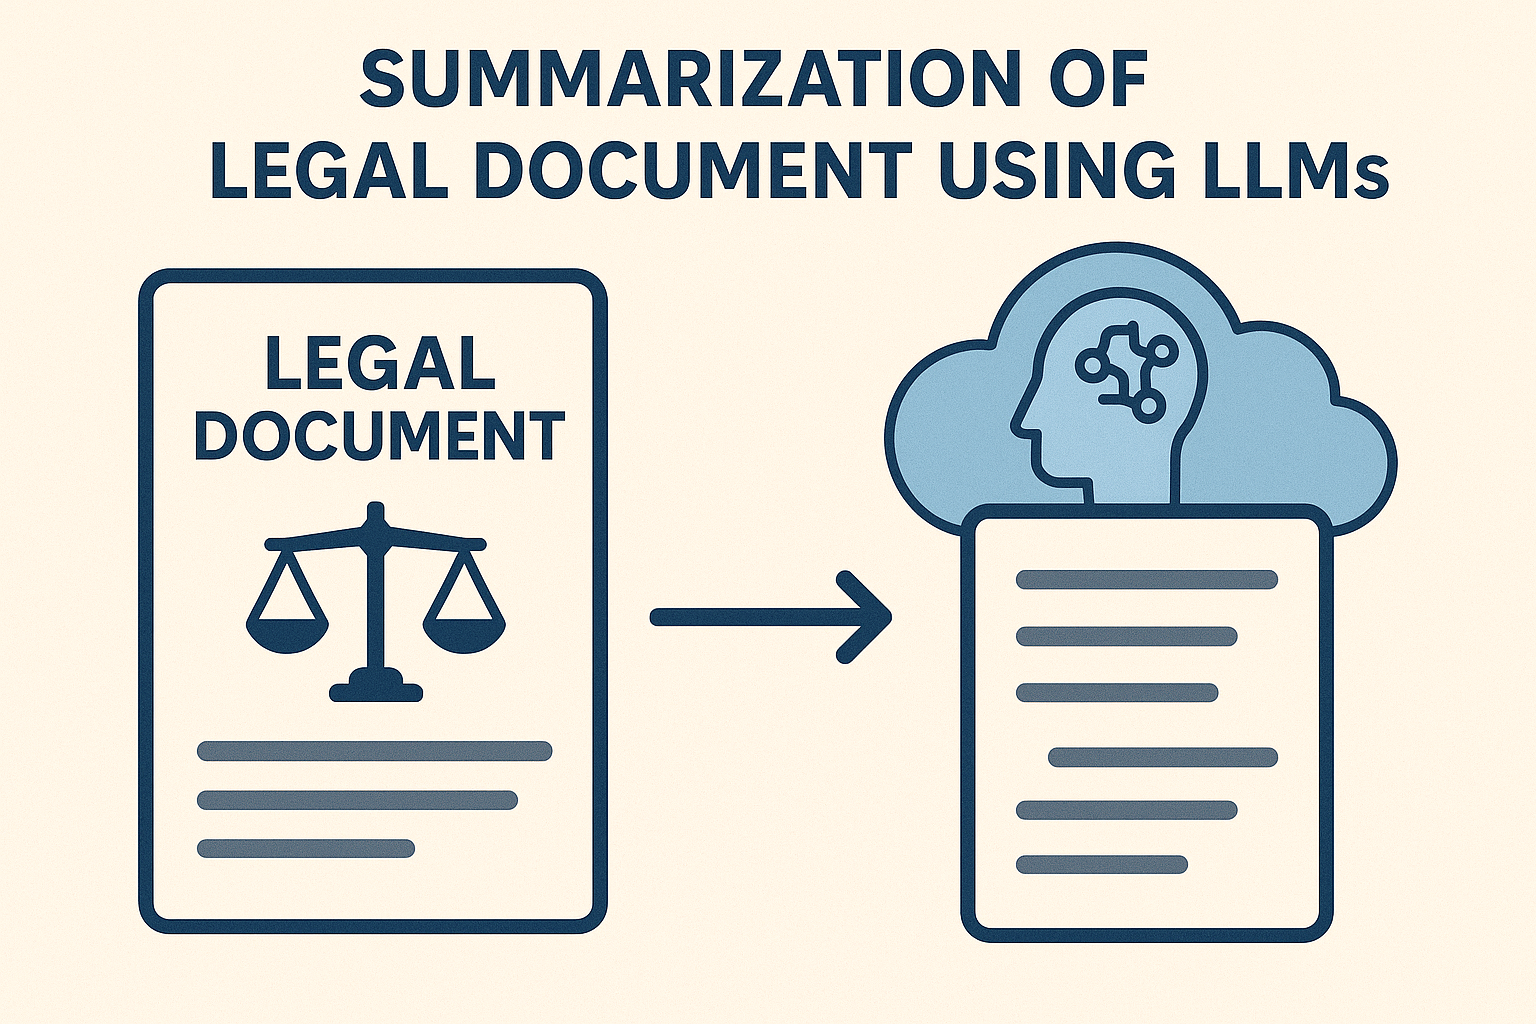

**Business Scenario: Summarisation of Legal Document**

Legal document summarization involves distilling complex legal texts—such as contracts, case law, regulatory filings, and statutes—into concise, accurate, and comprehensible summaries.

This process plays a critical role in enhancing the efficiency, speed, and accuracy of legal operations, especially in environments where time-sensitive decision-making is essential.

Traditionally, legal professionals had to manually sift through voluminous documentation to extract key clauses, obligations, or risks—an effort-intensive task prone to oversight and inconsistency.

With the advent of Large Language Models (LLMs) such as GPT-4, Claude, and other transformer-based architectures, this process can be significantly accelerated, enhancing the efficiency and accuracy of legal operations.

Trained on a vast corpus of legal and general texts, LLMs are capable of understanding domain-specific language, interpreting legal context, and generating coherent summaries that preserve the intent and nuance of the original documents.

By leveraging LLMs for summarization, legal teams can quickly surface critical information, streamline contract reviews, improve compliance monitoring, and reduce the cognitive load associated with interpreting dense legal texts.

Additionally, LLM-based summarization enables scalable processing of large document sets—ideal for use cases like due diligence, litigation discovery, regulatory audits, and more.

This not only enhances productivity but also democratizes access to legal insights by making complex documents easier to understand for non-specialists.

In this case study, we explore the use of **abstractive summarization** to condense complex legal case documents into concise, human-readable summaries.

Legal documents are typically dense, technical, and lengthy, making it difficult for professionals to quickly grasp the core issues, judgments, and outcomes.

Unlike **extractive summarization**, which selects verbatim sentences from the original text, abstractive summarization generates novel sentences that capture the essence of the content.

This is particularly useful in the legal domain where copying exact sentences may retain unnecessary legal jargon or scattered information, failing to provide a coherent summary.

Abstractive summarization allows for generating coherent, concise, and context-aware summaries that reflect the actual meaning, making them invaluable for use cases such as legal research, judgment analysis, and legal tech applications.

The dataset comprises court cases and legal decisions, including special leave petitions, appeals, and writ petitions, along with their summaries.

It consists of two splits - `example` and `gold_examples`, each with 10 rows and consists of two columns - `case_details_and_judgements` and `summary`

The following code loads the dataset using the `load_dataset` method.

In [35]:
# Loading the dataset for text summarization task
dataset = load_dataset("kaustuvkunal/legaldoc")

In [36]:
# Load the examples and gold examples from the original dataset and convert them to pandas dataframe
legaldoc_summary_examples_df = dataset['examples'].to_pandas()
legaldoc_summary_gold_examples_df = dataset['gold_examples'].to_pandas()

Extracting 4 legal record samples below.

In [37]:
# load the first 4 samples of the examples dataset
examples_df = legaldoc_summary_examples_df.sample(4, random_state=42)
examples_df

case_details_and_judgements  \
8  Special Leave Petition (Civil) No. 2391 of 198...   
1  : Special Leave Petition (Crl.) No. 1620 of 19...   
5  Special Leave Petition (Civil) No. 11638 of 19...   
0  cellaneous Petition No. 32937 of 1988.\r\n345 ...   

                                             summary  
8  The petitioners participated in the arbitratio...  
1  In so serious a crime as murder where so sever...  
5  In a petition for special leave against an int...  
0  On a civil miscellaneous petition for clarific...

## Few-Shot Prompts

As we have seen previously, the few-shot prompt outperforms the zero-shot prompt, so we will start iterative refinement with few-shot (instead of starting with zero-shot technique).

Similar to the above classification case, we use the Pandas DataFrame API's `iterrows` method on the examples DataFrame to append examples as user and assistant messages to the few-shot prompt.

In [38]:
# Iterate over the rows to get the first example and its summary (ground example)
for index, row in examples_df.iterrows():
    print('Example: Case Details')
    print(row.iloc[0])
    print('Example Summary:')
    print(row.iloc[1])
    break

Example: Case Details
Special Leave Petition (Civil) No. 2391 of 1987.
From the Judgment and Order dated 22.10.86 of the Bombay High Court in Appeal No. 439/82.
S.B. Bhasme and A.S. Bhasme for the Petitioners.
A.K. Gupta for the Respondents.
The Judgment.
of the Court was delivered by SABYASACHI MUKHARJI, J.
The High Court of Bombay dismissed PG NO 641 PG NO 642 the challenge to the award in question.
The award is an unreasoned one.
The transactions between the parties started some time in 1974.
The petitioners participated in the reference in 1979, without demur.
In 1981, the award was made.
No objection was taken at that time that the award was bad being an unreasoned one.
The matter is pending for a long time.
It is not desirable, in the interest of justice, to keep this matter pending because some cases are pending here on the question of the validity of unreasoned award per se.
The parties participated in the arbitration.
There is no allegation of any violation of principles of na

### Basic System Prompt

Let's define the basic system message prompt template

In [39]:
# Defining the system message
system_message_v1 = """
Summarize the  case details/judgements provided in the user input. Be specific and concise in your summary.
"""

In [40]:
# Create the system message prompt template
few_shot_prompt_v1 = [{'role': 'developer', 'content': system_message_v1}]

In [41]:
# Few-Shot Prompt Template
few_shot_prompt_v1

[{'role': 'developer',
  'content': '\nSummarize the  case details/judgements provided in the user input. Be specific and concise in your summary.\n'}]

 **Four-shot Prompting**

Creating a Four-Shot Prompt Template by extracting the first four rows in the dataset.

In [42]:
# Let's iterate over the 4 samples in examples_df and create a few-shot template
for index, row in examples_df.iterrows():
    user_input_example = row.iloc[0]
    assistant_output_example = row.iloc[1]

    few_shot_prompt_v1.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt_v1.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [43]:
# Few-Shot Prompt Template
few_shot_prompt_v1

[{'role': 'developer',
  'content': '\nSummarize the  case details/judgements provided in the user input. Be specific and concise in your summary.\n'},
 {'role': 'user',
  'content': 'Special Leave Petition (Civil) No. 2391 of 1987.\r\nFrom the Judgment and Order dated 22.10.86 of the Bombay High Court in Appeal No. 439/82.\r\nS.B. Bhasme and A.S. Bhasme for the Petitioners.\r\nA.K. Gupta for the Respondents.\r\nThe Judgment.\r\nof the Court was delivered by SABYASACHI MUKHARJI, J.\r\nThe High Court of Bombay dismissed PG NO 641 PG NO 642 the challenge to the award in question.\r\nThe award is an unreasoned one.\r\nThe transactions between the parties started some time in 1974.\r\nThe petitioners participated in the reference in 1979, without demur.\r\nIn 1981, the award was made.\r\nNo objection was taken at that time that the award was bad being an unreasoned one.\r\nThe matter is pending for a long time.\r\nIt is not desirable, in the interest of justice, to keep this matter pending

**Evaluation using BERTScore**

Since this task involves **abstractive summarization**, where the model generates new phrasings and sentence structures rather than copying text verbatim, traditional lexical overlap metrics like ROUGE or BLEU may fall short in capturing semantic similarity.

Therefore, we use **BERTScore** to evaluate the quality of the model's summaries against the available ground truth summaries.

----
**BERTScore is a semantic evaluation metric that leverages pre-trained contextual embeddings from transformer models like BERT.**

----


Instead of measuring surface-level word overlap, BERTScore computes similarity between each token in the generated summary and the reference summary based on their vector representations in a high-dimensional semantic space.

![BERT](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*mKfTGKo-nIsOHBFD9QcJiQ.png)

BERTScore aligns words with similar meanings—even if they differ lexically—and provides a more nuanced understanding of how closely the model's output aligns with human-written summaries.

This makes **BERTScore** particularly suitable for evaluating abstractive summaries, where semantic fidelity matters more than exact word match.

Using BERTScore allows us to capture subtle variations in phrasing while still penalizing outputs that deviate significantly in meaning from the reference.

In this setup, each generated summary is compared to its corresponding ground truth to compute precision, recall, and F1 based on token-level embedding similarity, providing a robust and interpretable evaluation of summarization performance.

The following function, `predict`, is designed to generate abstractive summaries for legal documents using the LLM and evaluate them against known gold (reference) summaries.

In [44]:
def predict(gold_examples_df, prompt):
    """Generates predictions for a set of gold examples using an LLM.

    Args:
        gold_examples_df (pd.DataFrame): A DataFrame containing gold examples
            with case details and judgements  and  output as its summaries.
            The first column should contain the legal content(case details and judgements),
            and the second column should contain the summary.
        prompt (list): A list of dictionaries containing the prompt for the LLM in the Open AI API format.

    Returns:
        tuple: A tuple containing two lists:
            - predictions (list): A list of predicted summaries.
            - ground_truths (list): A list of ground truth summaries.

    Raises:
        Exception: If an error occurs during prediction, it logs the error and continues.
    """
    predictions, ground_truths = [], []  # Initialize empty lists to store predictions and ground truths

    # Iterate through the gold examples DataFrame using tqdm for progress bar
    for index, row in tqdm(gold_examples_df.iterrows()):
        gold_input = row.iloc[0]  # Get the gold legal content input from the first column
        gold_summary = row.iloc[1]  # Get the gold summary from the second column

        # Skip if the input text is empty
        if not gold_input:
            continue

        # Format the legal input for the LLM
        user_input = [{'role':'user', 'content': gold_input}]
        try:
            # Generate a prediction using the LLM
            response = client.chat.completions.create(
                model=model_name,
                messages=prompt + user_input
                )

            predictions.append(response.choices[0].message.content)  # Store the prediction
            ground_truths.append(gold_summary)  # Store the ground truth
        except Exception as e:
            print(e)  # Log error and continue
            continue

    # Return the predictions and ground truths
    return predictions, ground_truths

In [45]:
predictions, ground_truths = predict(legaldoc_summary_examples_df , few_shot_prompt_v1)

10it [00:42,  4.28s/it]


In [46]:
# Loading the BERTScore model
bertscore = load("bertscore")

BERTScore Computation

In [47]:
# # Compute the BERTScore to evaluate semantic similarity between model predictions and ground truth texts

results = bertscore.compute(
    predictions=predictions,   # List of model-generated outputs
    references=ground_truths,  # List of reference texts
    lang="en"  # Language of the texts; 'en' indicates English
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The `results` variable will be a dictionary as shown below

In [48]:
results

{'precision': [0.8807862997055054,
  0.8410260677337646,
  0.8773424029350281,
  0.8627389073371887,
  0.9107204675674438,
  0.8911559581756592,
  0.8792423009872437,
  0.8461742997169495,
  0.8908116221427917,
  0.8455445766448975],
 'recall': [0.868449330329895,
  0.8557462692260742,
  0.8546936511993408,
  0.86195307970047,
  0.8932660818099976,
  0.8441672921180725,
  0.83655846118927,
  0.8548821210861206,
  0.8631666302680969,
  0.8646628260612488],
 'f1': [0.8745743036270142,
  0.848322331905365,
  0.8658698797225952,
  0.862345814704895,
  0.9019088745117188,
  0.8670254945755005,
  0.8573694825172424,
  0.8505058884620667,
  0.8767712712287903,
  0.8549968600273132],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.57.3)'}

Let's calculate the F1 score

In [49]:
sum(results['f1'])/len(results['f1'])

0.8659690201282502

The F1 Score comes out to be around 0.86, which is a good score.

Let's try refining the system prompt and few-shot prompts and evaluate the results.

### Refined System Prompt
The above score indicates that the summarization was of high quality.

Let us now try a different few-shot system message (keeping the examples the same) and see if we can improve this result.

In [50]:
system_message_v2 = """
You are a legal expert tasked with summarizing court judgments, petitions, and appeals.
Your summaries must be concise, accurate, and structured, capturing the key legal principles, facts, and outcomes while omitting redundant details.

Use the following guidelines for your summary:
1. Extract key elements: case context, legal issue, judgment with HELD section, and critical references.
2. Structure with opening line, numbered legal principles in HELD section, and retained paragraph markers.
3. Omit procedural history, lengthy citations, and redundant details.
4. Maintain formal, neutral tone in passive voice under 150 words.
"""

In [51]:
# Create the prompt template for the system message
few_shot_prompt_v2 = [{'role':'developer', 'content': system_message_v2}]

In [52]:
# Iterate over the rows in examples_dfs and create few shot examples and apped to the prompt template
for index, row in examples_df.iterrows():
    user_input_example = row.iloc[0]
    assistant_output_example = row.iloc[1]

    few_shot_prompt_v2.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt_v2.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [53]:
# Few shot prompt template
few_shot_prompt_v2

[{'role': 'developer',
  'content': '\nYou are a legal expert tasked with summarizing court judgments, petitions, and appeals.\nYour summaries must be concise, accurate, and structured, capturing the key legal principles, facts, and outcomes while omitting redundant details.\n\nUse the following guidelines for your summary:\n1. Extract key elements: case context, legal issue, judgment with HELD section, and critical references.\n2. Structure with opening line, numbered legal principles in HELD section, and retained paragraph markers.\n3. Omit procedural history, lengthy citations, and redundant details.\n4. Maintain formal, neutral tone in passive voice under 150 words.\n'},
 {'role': 'user',
  'content': 'Special Leave Petition (Civil) No. 2391 of 1987.\r\nFrom the Judgment and Order dated 22.10.86 of the Bombay High Court in Appeal No. 439/82.\r\nS.B. Bhasme and A.S. Bhasme for the Petitioners.\r\nA.K. Gupta for the Respondents.\r\nThe Judgment.\r\nof the Court was delivered by SABYA

**Evaluation**

In [54]:
predictions, ground_truths = predict(legaldoc_summary_gold_examples_df, few_shot_prompt_v2)

10it [00:34,  3.42s/it]


In [55]:
# Compute the BERTScore to evaluate semantic similarity between model predictions and ground truth texts
results = bertscore.compute(
    predictions=predictions, # List of model-generated outputs
    references=ground_truths, # List of reference texts
    lang="en" # Language of the texts; 'en' indicates English
)

In [56]:
sum(results['f1'])/len(results['f1'])

0.8677416920661927

The **F1 score** is higher this time around - there is a slight improvement with this prompt.  

Therefore, we can now use it as our final prompt for summarizing legal documents.

In [57]:
final_system_message ="""
You are a legal expert tasked with summarizing court judgments, petitions, and appeals.
Your summaries must be concise, accurate, and structured, capturing the key legal principles, facts, and outcomes while omitting redundant details.

Use the following guidelines for your summary:
1. Extract key elements: case context, legal issue, judgment with HELD section, and critical references.
2. Structure with opening line, numbered legal principles in HELD section, and retained paragraph markers.
3. Omit procedural history, lengthy citations, and redundant details.
4. Maintain formal, neutral tone in passive voice under 150 words.
"""

Let's leverage this to summarise a legal appeal content.

In [58]:
appeal = """
These three appeals by special leave are directed against the order dated september 92004 passed by intellectual property appellate board for shortipab whereby it ordered the removal of appellant 's mark infosys from the register of trade marks in respect of computer stationery computer manuals printed matter for computer instructional and teaching materials computer hardware and peripherals and machine and machine tools.
the appellant is infosys technologies limited.
it was incorporated and registered under the companies act1956 on july 21981 in the name of infosys consultants private limited.
the appellant got the trade mark infosys registered in 1987 in classes 16 and 9 in connection with computer stationery computer manuals printed manual for computer instruction and teaching materials computer hardwares computer interface computer peripherals electronics telex interface and in 1988 in class 7 in connection with machine and machine tools and motors not for land vehicles the particulars with reference to the trade mark registered by the appellant are as follows.
on april 211992the name of the company infosys consultants pvt.
limited was changed to infosys technologies pvt.
ltd and thereafter on june 21992the name was changed to the present name i e.
infosys technologies limited.
the first respondent is jupiter infosys limited.
the first respondent was incorporated and registered in september 1978 under the name of jupiter agencies pvt.
limited.
the name of the first respondent was changed to jupiter infosys p limited in august1995 and now since july2003the name is changed to jupiter international limited.
on october 111996the appellant instituted a suit in the calcutta high court for perpetual injunction inter alia restraining the first respondent from infringing the appellant 's mark infosys by using the mark infosys by itself or in combination with other marks in course of its trade.
the appellant also prayed for an interim order in the suit.
on november 221996the calcutta high court by an ad interim order restrained the first respondent from using the word infosys in any manner in relation to the goods for the time being.
the ad interim order was confirmed on november 291996.
the appellant having come to know of several instances of misuse of mark infosys also filed a writ petition being writ petition no 14214 of 2000 before the calcutta high court inter alia praying that the registrar of companies be restrained from registering the companies bearing the name infosys.
on september 132000the calcutta high court restrained the department of company affairs and registrar of companies from incorporating any company bearing the name infosys without the permission of the appellant.
in january 2001the appellant filed yet another suit before the high court of judicature at madras for permanent injunction restraining the first respondent from offering shares to the public as claimed in the initial public offer ipo using infosys.
the single judge of the madras high court passed an interim restraint order on february 12001 against the first respondent.
the said order was confirmed on may 222001 to remain operative till disposal of suit.
the first respondent then filed three separate applications before the madras high court inter alia under sections 46 and 56 of the trade and merchandise marks act1958.
the 1958 act in o p no 764 of 2001the first respondent prayed for the removal rectification of the entry in the register of trade mark in respect of trade mark no 475269 in class 16 while in the other two applications being o p no 765 of 2001 and o p no 766 of 2001the first respondent prayed for removal rectification of trade mark no 475267 in class 9 and trade mark no 484837 in class 7 respectively.
the appellant opposed these applications on diverse grounds by filing counter affidavits.
on august 122003the madras high court framed the following issues.
a whether the mark applied for registration was used in respect of the goods for which the mark was registered.
b whether the respondent had a bonafide intention to use the mark applied for under section 18 of the trade and merchandise marks act.
cwhether the mark registered in favour of the respondent is a service mark.
dwhether there is a non use of registered trade mark by the respondent for a period of over 5 years and 1 month.
ewhether the registered trade mark is disentitled for protection in a court of law under section 11e of the trade and merchandise marks act.
fwhether the registered trade mark has lost its distinctiveness and is liable to be removed under section 32c.
g whether the respondent has committed fraud while obtaining registration of the mark and.
hto what further relief.
the 1958 act was repealed by the trade marks act1999 for shortthe 1999 act in terms of section 100 of the 1999 act the three petitions filed by the first respondent before the madras high court for rectification removal of registered trade mark nos 475269475267 and 484837 were transferred to the ipab.
some more facts may be noticed.
the appellant filed yet another suit being suit no 2115 of 2002 before delhi high court for infringement of trade mark and passing off against the first respondent.
in that suit the appellant also made an application for grant of temporary injunction.
the vacation judge of the delhi high court on december 272002 passed an order of temporary injunction against the first respondent as follows notice for 24th march2003 before the joint registrar.
heard.
perused the averments made in the suit and application which are duly supported by documents on record.
i am of the opinion that in case ex parte ad interim orders are not granted the relief claimed itself may be rendered infructuous.
accordingly it is directed that pending further consideration of the matter after notice for the next date of hearing the defendants are restrained by themselves their directors employees agents andor others acting on its behalf from using the trade mark corporate name infosys or any other mark name deceptively similar trade mark or colourable imitation thereof as a mark andor corporate name or as part of a mark andor business name in respect of goods andor services for publicity on propaganda on websites and or in domain names in any way whatsoever thereby causing infringement of the registered trade mark infosys of the plaintiff in isolation or in combination with words letters numbers their advertisements as part of their corporate name either in isolation or in goods and services or in or by way of any advertisement publicity campaigns etc.
compliance of order xxxix rule 3 cpc within three days.
the said suit was transferred to the court of the additional district judge tis hazari court delhi.
in that suit an affidavit came to be filed by the first respondent wherein it was stated that the name of the company has been changed from jupiter infosys limited to jupiter international limited and a certificate to that effect has been issued by the registrar of companies kolkata under the companies act1956 and no dispute remains between the parties under the trade mark.
the relevant statement made in the affidavit dated july 142003 we were informed that the date of the affidavit is july 142004 reads as follows that in the meantime the defendant has already changed the trade mark namely jupiter international ltd in place of jupiter infosys ltd the copy of the incorporation on change of name which was issued by the registrar of the companies are being marked and annexed herewith as annexure a that now there is no dispute between the plaintiff and defendant under the trade mark.
based on this affidavit the suit was partially decreed in favour of the appellant on november 102004.
in 2007however the first respondent filed a suit in the court of additional district judge delhi for setting aside the decree dated november 102004 that suit is said to be pending.
the ipab proceeded with the matter in light of the issues that were already framed by the high court and heard the parties.
the ipab in the impugned order while dealing with the plea of limitation raised by the appellant held that the first respondent was the appropriate aggrieved party in the matter in view of the fresh cause of action having arisen to the first respondent on filing of civil suit no 71 of 2001 by the appellant before the madras high court.
the ipab in the impugned order held that the trade mark nos 475269475267 and 484837 have not been used by the appellant for more than a period of five years and one month and the appellant also failed to make out that it had been in manufacturing or trading of the goods for which it had taken registration nos 475269475267 and 484837 consequently the ipab allowed the applications made by the first respondent purportedly under section 461b of the 1958 act and directed the registrar to remove these registrations from the register.
we heard mr akhil sibal learned counsel for the appellant and mr vaibhav gaggar learned counsel for the first respondent at quite some length.
mr akhil sibal learned counsel for the appellant argued that an application for rectification whether under section 46 or section 56 of the 1958 act can only be preferred by a person aggrieved the applicant must not only be a person aggrieved on the date of the application but must continue to remain a person aggrieved until such time as the rectification application is finally decided.
he contended that the first respondent is not shown to have ever traded or intended to trade in any goods covered by the appellant 's registrations under classes 7 and 16 and as such the first respondent is not a person aggrieved with regard to the appellant 's registrations under these two classes.
as regards class 9 he would submit that in view of the affidavit filed by the first respondent on july 142004 in the court of additional district judge delhi the first respondent ceases to be an aggrieved person on the date of consideration of the rectification application.
learned counsel heavily relied upon two decisions of this court 1 hardie trading ltd anr v.
addisons paint chemicals ltd 2003 11 scc 92 2003 indlaw sc 756 and 2 kabushiki kaisha toshiba v tosiba appliances company ors 2008 10 scc 766 2008 indlaw sc 1395.
assailing the finding of the ipab as regards non use by the appellant during the relevant period learned counsel for the appellant argued that the said finding was erroneous on legal as well as factual premise.
he contended that the ipab erred in holding that software was a service and the subject registrations were in relation to goods without considering the wide definition of goods provided under section 2g of the 1958 act.
akhil sibal argued that the ipab committed grave error in relying upon the provisions of the 1999 act and the trade marks rules2002 when these provisions were not applicable as the applications were filed under the 1958 act.
according to him the ipab sought to rely upon computer programming which is a service enumerated in class 42without considering the distinction between a computer programme and computer programming and without noticing the entry computer under class 9 which falls within goods.
learned counsel would submit that in examining the question of non use under section 461bthe ipab failed to consider that the requisite use must be in relation to goods under registration which is extensively defined under section 22b of the 1958 act.
akhil sibal learned counsel also argued that the ipab failed to have regard to the proviso to section 461in terms of which it is open to the registered proprietor to rely upon use of the registered trade mark during the relevant period in relation to goods of the same descriptionin order to resist an application for rectification.
he contended that the ipab failed to apply proper legal tests for determining goods of the same description and had that been done it would be evident that computer software amounts to goods of the same description as computer hardware.
in this regard he relied upon m s eagle potteries.
private ltd v.
m s eagle flask industries pvt.
ltd air 1993 bombay 185 1992 indlaw mum 6327 lever brothers port sunlight ld v.
sunniwite products ld 1949 66 rpc 84.
the ritz hotel v charles of the ritz 1989.
rpc 333 and australian wine importers trade mark.
6 rpc 311.
learned counsel for the appellant also submitted that in any view of the matter the ipab erred in exercising its discretion under section 46 of the 1958 act without taking into consideration the aspect of public interest.
he argued that the ipab ought to have considered whether use of mark infosys by the first respondent on computer hardware would create confusion in the mind of the consumers that they might be led to believe that the said hardware is manufactured by the appellant.
learned counsel thus submitted that the impugned order is unsustainable and liable to be set aside.
on the other hand an objection is raised in the written submissions on behalf of the first respondent and reference was made in support of the objection to seven judge bench decision of this court in l chandrakumar v union of india ors 1997 3 scc 261 1997 indlaw sc 2816 that challenge to the order of ipab directly in the appeal before this court under article 136 of the constitution is barred.
in reply to the arguments of learned counsel for the appellant mr vaibhav gaggar learned counsel for the first respondent strenuously urged that the plea of aggrieved person is a new plea and raised substantially for the first time before this court.
he argued that the appellant has not taken the plea of the first respondent not being a person aggrieved with respect to filing of the applications for rectification before the ipab merely urging the plea that the first respondent has no locus standi in the written submissions before the ipab is not sufficient.
learned counsel would submit that the appellant has for the first time argued before this court that the first respondent is not a person aggrieved andor not capable of maintaining the rectification proceedings with respect to each and every good for which the appellant has been registered since the first respondent has not been registered for all the goods.
vaibhav gaggar rather asserted that the first respondent is a person aggrieved in view of the fact that various suits for infringement have been filed by the appellant against the first respondent and on the date of the applications for rectification removal of the subject registrations from the register the suits were pending.
with reference to the affidavit dated july 142004 filed by the first respondent before the court of additional district judge he submitted that the said affidavit has no relevance in consideration as to whether the first respondent is an aggrieved person as section 46 1 of the 1958 act relates only to the period upto the date of the filing of the rectification application and the rights of the parties crystallized at that stage itself.
in this regard he relied upon a decision of the madras high court in agha hyder hussain anr v.
omar khayyam wineries pvt ltd anr air 1977 mad 166.
1976 indlaw mad 380.
he also placed reliance upon some more decisions viz ritz hotel ltd 1989.
rpc 333philosophy di alberta ferretti 2003 r p c 15.
keystone knitting mills trade mark1929 1 ch.
d 92 and motor terms company pty limited v.
liberty insurance ltd 1967 116 c l r 177 learned counsel for the first respondent further submitted that the affidavit dated july 142004 was not placed by the appellant before the ipab nor any reference of the said affidavit has been made in the written submissions before the ipab and the appellant also did not make any effort to amend the pleadings that the first respondent was not an aggrieved person.
it was contended by mr vaibhav gaggar that even otherwise in view of the fraud perpetrated by the appellant qua the registrations in question the issue as to whether the first respondent had a dispute with the trade mark or not pales into insignificance as the primary duty of the court is to maintain the purity of the register.
he argued that in a case such as the present one since the allegations against the appellant relate to trafficking squatting and non user the scope of person aggrieved has to be enlarged.
learned counsel submitted that the fact that the appellant continues to allege and that stance has not changed in the pleadings in slp as well that the first respondent is an infringer pilfriger defrauder someone who wants to ride on the goodwill of the appellant or someone who wants to mislead the public at large there is no question of the first respondent ceasing to be a person aggrieved at any stage.
vaibhav gaggar learned counsel for the first respondent contended that the appellant is registered as a manufacturer and trader under classes 79 and 16 even though it is a company engaged in software only.
moreover there is nothing on record to indicate linkage with the manufacturing or marketing of the goods for which the appellant is holding registration of subject trade marks.
he vehemently contended that goods in classes 79 and 16 for which the appellant obtained registration were never used in the manner contemplated by the 1958 act for almost 30 years and that would show the mala fide intention of the appellant in having the same registered for the purpose of squatting and trafficking.
learned counsel for the first respondent further argued that infosys is not an invented or a coined word the said word is an abbreviation and combination of the words information system the word infosys has been used by various companies abroad as well as within india prior to incorporation of the appellant itself and hence can not be called an invented word.
in this regard he relied upon a decision of the madras high court in nestle 's products india.
ltd v.
p thankaraja.
anr air 1978 mad 336 he submitted that appellant is primarily in service industry which is unregistrable under the 1958 act and since the appellant is not trading in the goods in respect of which it is registered it can not be said that the mark of the appellant is distinctive of its goods.
in any case learned counsel would submit that the expression infosys is not descriptive expression.
insofar as discretion exercised by ipab in ordering removal of the appellant 's registrations from the register under section 461b of the 1958 act is concerned learned counsel for the first respondent submitted that this court should not overturn the discretion so exercised by the ipab keeping in view the dishonest and fraudulent conduct of the appellant.
lastly he submitted that although no cross objections or cross appeal has been filed the first respondent has some grievance with regard to the order of the ipab in not considering the case set up in the rectification removal applications particularly with regard to section 56 of the 1958 act.
having regard to the order that we intend to make we are not persuaded to accept the objection raised on behalf of the first respondent that present appeal preferred directly before this court from the impugned order passed by the ipab is not maintainable and must be dismissed as such.
pertinently the notice was issued in the petitions for special leave to appeal to the respondents on november 12004 in response to the said notice the first respondent filed counter affidavit before this court on march 112005 wherein no specific objection about invocation of jurisdiction of this court directly has been taken.
in the counter affidavit a very vague objection in the following terms was raised that the present petition apart from being false and misconceived lacks the necessary jurisdiction hence deserves outright rejection.
we are afraid this is hardly an objection about maintainability.
apart from it on september 122005 after hearing both parties special leave was granted by this court.
in the backdrop of these peculiar facts in our view it is not appropriate to relegate the 17 appellant at this distance of time to challenge the impugned order passed by the ipab in writ petition before the high court.
the objection about maintainability of the appeals is accordingly overruled.
the moot question which has been debated before us is whether or not the first respondent is an aggrieved person.
that the first respondent filed composite applications under sections 46 and 56 of the 1958 act for rectification removal of the trade mark infosys registered in classes 79 and 16 is not in dispute.
sections 46 and 56 read as follows s 46 removal from register and imposition of limitations on ground of non use   1 subject to the provisions of section.
47a registered trade mark may be taken off the register in respect of any of the goods in respect of which it is registered on application made in the prescribed manner to a high court or to the registrar by any person aggrieved on the ground either a that the trade mark was registered without any bona fide intention on the part of the applicant for registration that it should be used in relation to those goods by him or in a case to which the provisions of section 45 apply by the company concerned and that there has in fact been no bona fide use of the trade mark in relation to those goods by any proprietor thereof for the time being up to a date one month before the date of the application or b that up to a date one month before the date of the application a continuous period of five years or longer had elapsed during which the trade mark was registered 18 and during which there was no bona fide use thereof in relation to those goods by any proprietor thereof for the time being provided that except where the applicant has been permitted under sub section 3 of section 12 to register an identical or nearly resembling trade mark in respect of the goods in question or where the tribunal is of opinion that he might properly be permitted so to register such a trade mark the tribunal may refuse an application under clause a or clause b in relation to any goods if it is shown that there has been before the relevant date or during the relevant period as the case may be bona fide use of the trade mark by any proprietor thereof for the time being in relation to goods of the same description being goods in respect of which the trade mark is registered.
2 where in relation to any goods in respect of which a trade mark is registered a the circumstances referred to in clause 1 of sub section 1 are shown to exist so far as regards non use of the trade mark in relation to goods to be sold or otherwise traded in in a particular place in india otherwise than for export from indiaor in relation to goods to be exported to a particular market outside india and b a person has been permitted under sub section 3 of section 12 to register an identical or nearly resembling trade mark in respect of those goods under a registration extending to use in relation to goods to be so sold or otherwise traded in or in relation to goods to be so exported or the tribunal is of opinion that he might properly be permitted so to register such a trade mark on application by that person in the prescribed manner to a high court or to the registrar the tribunal may impose on the registration of the first mentioned trade mark such limitations as it thinks proper for securing that that registration shall cease to extend to such use 19 3.
an applicant shall not be entitled to rely for the purpose of clause b of sub section 1 or for the purposes of sub section 2 on any non use of a trade mark which is shown to have been due to special circumstances in the trade and not to any intention to abandon or not to use the trade mark in relation to the goods to which the application relates.
s 56 power to cancel or vary registration and to rectify the register 1.
on application made in the prescribed manner to a high court or to the registrar by any person aggrieved the tribunal may make such order as it may think fit for cancelling or varying the registration of a trade mark on the ground of any contravention or failure to observe a condition entered on the register in relation thereto.
any person aggrieved by the absence or omission from the register of any entry or by any entry made in the register without sufficient cause or by any entry wrongly remaining on the register or by any error or defect in any entry in the register may apply in the prescribed manner to a high court or to the registrar and the tribunal may make such order for making expunging or varying the entry as it may think fit.
the tribunal may in any proceeding under this section decide any question that may be necessary or expedient to decide in connection with the rectification of the register.
the tribunal of its own motion may after giving notice in the prescribed manner to the parties concerned and after giving them an opportunity of being heard make any order referred to in sub section 1 or sub section 2.
any order of the high court rectifying the register shall direct that notice of the rectification shall be served upon the registrar in the prescribed manner who shall upon receipt of such notice rectify the register accordingly.
the power to rectify the register conferred by this section shall include the power to remove a trade mark registered in part a of the register to part b of the register.
the position that emerges from the above provisions is this.
whether the application is under section 46 or under section 56 or a composite application under both sections it is a pre requisite that the applicant must be a person aggrieved.
section 461 of the 1958 act enables any person aggrieved to apply for removal of registered trade mark from the register on the ground of non use as stated in clause a andor clause b to be an aggrieved person under section 46he must be one whose interest is affected in some possible way it must not be a fanciful suggestion of grievance.
a likelihood of some injury or damage to the applicant by such trade mark remaining on the register may meet the test of locus standi.
in kerly 's law of trade marks and trade names 11th edition at page 166the legal position with regard to person aggrieved has been summarized thus the persons who are aggrieved are all persons who are in some way or the other substantially interested in having the mark removed where it is a question of removal from the register including all persons who would be substantially damaged if the mark remained and all trade rivals over whom an advantage was gained by a trader who was getting the benefit of a registered trade mark to which he was not entitled.
we accept the above statement of law.
insofar as section 56 is concerned it provides for varying situations in which the person aggrieved may apply for rectification of the registered trade mark from the register.
although both sections namely sections 46 and 56 require person aggrieved to apply for removal of the registered trade mark from the register or rectification of a trade mark in the register the expression person aggrieved for the purposes of these two sections has different connotations.
the interpretation of the expression person aggrieved occurring in sections 46 and 56 has come up for consideration before this court on more than one occasion.
in hardie trading ltd 2003 indlaw sc 756 2003 11 scc 92this court stated as follows the phrase person aggrieved is a common enough statutory precondition for a valid complaint or appeal.
the phrase has been variously construed depending on the context in which it occurs.
three sections viz sections 4656 and 69 of the act contain the phrase.
section 46 deals with the removal of a registered trade mark from the register on the ground of non use.
this section presupposes that the registration which was validly made is liable to be taken off by subsequent non user.
section 56 on the other hand deals with situations where the initial registration should not have been or was incorrectly made.
the situations covered by this section include a the contravention or failure to observe a condition for registration b the absence of an entry c an entry made without sufficient cause d a wrong entry and e any error or defect in the entry.
such type of actions are commenced for the purity of the register which it is in public interest to maintain.
applications under sections 46 and 56 may be made to the registrar who is competent to grant the relief.
persons aggrieved may also apply for cancellation or varying an entry in the register relating to a certification trade mark to the central government in certain circumstances.
since we are not concerned with a certification trade mark the process for registration of which is entirely different we may exclude the interpretation of the phrase person aggrieved occurring in section 69 from consideration for the purposes of this judgment.
in our opinion the phrase person aggrieved for the purposes of removal on the ground of non use under section 46 has a different connotation from the phrase used in section 56 for cancelling or expunging or varying an entry wrongly made or remaining in the register.
in the latter case the locus standi would be ascertained liberally since it would not only be against the interest of other persons carrying on the same trade but also in the interest of the public to have such wrongful entry removed.
it was in this sense that the house of lords defined person aggrieved in the matter of powell 's trade mark although they were no doubt inserted to prevent officious interference by those who had no interest at all in the register being correct and to exclude a mere common informer it is undoubtedly of public interest that they should not be unduly limited inasmuch as it is a public mischief that there should remain upon the register a mark which ought not to be there and by which many persons may be affected who nevertheless would not be willing to enter upon the risk and expense of litigation.
whenever it can be shown as here that the applicant is in the same trade as the person who has registered the trade mark and wherever the trade mark if remaining on the register would or might limit the legal rights of the applicant so that by reason of the existence of the entry on the register he could not lawfully do that which but for the existence of the mark upon the register he could lawfully do it appears to me he has a locus standi to be heard as a person aggrieved.
but if the ground for rectification is merely based on non user i e under section 46 of the act that is not really on account of any public mischief by way of an incorrect entry.
the non user does not by itself render the entry incorrect but it gives a right to a person whose interest is affected to apply for its removal.
an applicant must therefore show that in some possible way he may be damaged or injured if the trade mark is allowed to stand and by possible i mean possible in a practical sense and not merely in a fantastic view.
all cases of this kind where the original registration is not illegal or improper ought to be considered as questions of common sense to a certain extent at any rate and i think the applicants ought to show something approaching a sufficient or proper reason for applying to have the trade mark expunged.
it certainly is not sufficient reason that they are at loggerheads with the respondents or desire in some way to injure them.
addisons application was one under section 46 and the test to determine whether the applicant was a person aggrieved within the meaning of that section should have been the one laid down by romer j in wright case and not the one propounded by the house of lords in the matter of powell 's trade mark.
the high court and the joint registrar fell into error in not drawing this distinction.
however it is not necessary to dilate on this aspect of the matter as the appellant has really argued on the second and third aspects of section 46 viz the alleged non use of the trade marks by hardie and special circumstances.
in the case of hardie trading ltd 2003 indlaw sc 756 1this court approved the test applied by romer j in the royal baking powder company v wright crossley and co 1898.
15 rpc 677which has been reproduced in the report.
we respectfully agree.
hardie trading ltd 2003 indlaw sc 756 1 has been followed by this court in a recent decision in the case of kabushiki kaisha toshiba 2008 10 scc 766 2008 indlaw sc 1395.
this court stated that section 46 speaks for private interest while section 56 speaks of a public interest.
it is true that the appellant in opposition to the applications for removal rectification of trade mark did not specifically challenge in its counter affidavits the locus standi of the first respondent to be heard as a person aggrieved.
obviously in the absence of any specific objection by the appellant to that effect no specific issue was framed by the high court whether the applicant was an aggrieved person.
the applications having been transferred to the ipab in terms of section 100 of the 1999 act the ipab examined the matter in light of the issues that were framed by the high court although in the written submissions before it the objection was raised that the first respondent has ceased to have locus standi in view of the subsequent events particularly change of the name of the first respondent from jupiter infosys ltd to jupiter international ltd the question is whether in these circumstances it was incumbent upon the ipab to consider and satisfy itself about the locus standi of the first respondent to be heard as a person aggrieved.
in our considered view it was.
in the first place when the first respondent applied for rectification removal in respect of three registrations in classes 79 and 16it must have shown in respect of each of them that it is a person aggrieved and the ipab must have separately considered in respect of each registration the locus standi of the first respondent as the considerations for each entry might not have been common.
secondly and more importantly during the pendency of the applications certain events had taken place which had some bearing on the question of locus standi of the first respondent insofar as invocation of section 46 1 of the 1958 act is concerned.
in the affidavit filed by the first respondent on july 142004 before the court of additional district judge delhi an unequivocal and categorical statement has been made that now there is no dispute between the plaintiff appellant herein and defendant first respondent herein under the trade mark and that defendant has already changed the trade mark namely jupiter international ltd in place of jupiter infosys ltd in terms of section 461not only that the applicant has to show that he is an aggrieved person as his interest is being affected but the ipab must also be satisfied before it directs the removal of registered trade mark that the applicant is an aggrieved person before it invokes the power in directing the removal of the 26 registered trade mark.
this is so because the pre requisite for exercise of power under section 461 is that the applicant is a person aggrieved.
the question then arises whether it is sufficient for the applicant to show that he is a person aggrieved when he makes his application or he must continue to remain a person aggrieved until such time as the rectification removal application is finally decided.
in our view the grievance of the applicant when he invokes section 461 must not only be taken to have existed on the date of making application but must continue to exist when such application is decided.
if during the pendency of such application the applicant 's cause of complaint does not survive or his grievance does not subsist due to his own action or the applicant has waived his right or he has lost his interest for any other reason there may not be any justification for rectification as the registered trade mark can not be said to operate prejudicially to his interest.
in re apollinaris company 's trade marks while dealing with this aspect kekemich j stated because that is a remedy given to the person aggrieved through the interposition of the court for the benefit of the 14 1891 2 ch 186 27 applicant and if at the date of the trial he has no cause of complaint it seems to be monstrous to suppose that the court will rectify the register at his instance when it can do him no good to rectify and when the retention on the register can do him no harm merely because at the date of his application he may have had some grievance.
we concur with the above statement.
in the circumstances we are satisfied that the applications made by the first respondent for rectification removal of the subject trade marks from the register need to be considered afresh by the ipab in accordance with law and the observations made above.
since the first respondent has also grievance in connection with the impugned order particularly with regard to non consideration of its case under section 56 of the 1958 act we refrain from going into the merits of the diverse contentions raised before us and leave the parties to agitate these contentions before the ipab.
in view of the above these appeals are allowed in part and the impugned order dated september 92004 is set aside.
the applications being tra nos 25 to 27 of 2003 op nos 764 to 766 of 2001 are restored to the file of intellectual property appellate board chennai for hearing and disposal afresh in accordance with law.
the parties shall bear their own costs.
appeals allowed.
"""

In [59]:
final_prompt = [{'role': 'developer', 'content': final_system_message}]
user_input = [{'role': 'user', 'content': appeal}]

In [60]:
response = client.chat.completions.create(
    model=model_name,
    messages=final_prompt + user_input
)

print(response.choices[0].message.content)

The three appeals challenge the IPAB's order dated September 9, 2004, which directed the removal of Infosys Technologies Limited's trade mark "Infosys" from the trade mark register concerning various goods. 

HELD:
1. The IPAB's determination that the first respondent was an "aggrieved person" was contested, emphasizing that such status must persist until the application is adjudicated.
2. The appellant failed to prove continuous use of the registered trade marks over five years, leading to their potential removal under Section 46 of the 1958 Act. 
3. The case will be reconsidered by the IPAB on its merits, including the first respondent’s claims under Section 56.

The appeals are partially allowed; the IPAB's order is set aside, and the applications are reinstated for re-evaluation.


**Alternative Method**

### LLM-as-a-judge

As an alternative method to evaluate the quality of the output, let us use the LLM-as-a-Judge with *completeness*, *veracity*, *structure*, and *terminological rigor* as the four evaluation metrics. The final score is the mean of all the scores.

In [61]:
# Let's define the model for LLM-as-a-Judge method
rater_model = 'gpt-4o'

The following code defines the system message for the LLM-as-a-Judge method.

It defines the LLM role as an evaluator of AI-generated summaries of Indian court judgments.

It provides clear evaluation criteria and metrics—completeness, veracity, structure, and terminological rigor—each to be rated on a 1 to 5 scale.

The message outlines the expected input format (Legal-doc and Summary) and a step-by-step evaluation process for comparing the summary against the original legal document.

The output must be a structured JSON object containing individual scores, an overall score, and concise feedback.

This setup ensures consistent, objective, and criteria-driven assessment of legal text summarizations.

In [62]:
# Defining the system message for the text summarization task
rater_system_message = """
You are tasked with evaluating AI-generated summaries of Indian court judgments against the original legal documents.

### Input Format:
- ###Legal-doc: The original court judgment text
- ###Summary: The AI-generated summary to be evaluated

### Evaluation Criteria (Rate 1-5):
1 - Criteria not met
2 - Minimally met
3 - Partially met
4 - Mostly met
5 - Fully met

### Evaluation Metrics:
1. COMPLETENESS:
   - Includes all key elements: case context, legal issue, judgment (HELD section), and references
2. VERACITY:
   - All facts and legal principles are correctly extracted from the original
   - No unsupported claims or misinterpretations
3. STRUCTURE:
   - Follows required format: opening line, numbered HELD points, paragraph references
4. TERMINOLOGICAL RIGOR:
   - Uses exact legal terminology from judgment
   - Maintains neutral, formal tone
   - Stays under 100 words

### Evaluation Process:
1. Analyze the original Legal-doc to identify key elements
2. Compare each element with the summary
3. Note any missing, incorrect, or extraneous information
4. Assess adherence to structure and style requirements
5. Assign scores for each metric
6. Calculate final score (average of metric scores)

### Output Format:
```json
{
    "score": [1-5],
    "completeness": [1-5],
    "veracity": [1-5],
    "structure": [1-5],
    "terminological-rigor": [1-5],
    "feedback": "Concise evaluation notes"
}

"""

Let's define the user message template

In [63]:
# Define the user message template
rater_user_message_template = """
###Legal-doc
{case_details_and_judgements}

###Summary
{summary}
"""

The following code evaluates LLM-generated summaries of legal documents by using another LLM as a rater.

It iterates over legal document + predicted summary pair, constructs a structured prompt for a rating LLM and submits the prompt to an LLM to rate the summary based on quality metrics defined.

In [64]:
# Creating an empty list to store all the ratings
ratings = []

for gold_case_details_and_judgements, prediction in tqdm(zip( legaldoc_summary_gold_examples_df.case_details_and_judgements, predictions)):

    rater_prompt = [
        {
            'role': 'developer',
            'content': rater_system_message
        },
        {
            'role': 'user',
            'content': rater_user_message_template.format(
                case_details_and_judgements=gold_case_details_and_judgements,
                summary=prediction
            )
        }
    ]

    response = client.chat.completions.create(
        model=rater_model,
        messages=rater_prompt
    )

    ratings.append(response.choices[0].message.content)

10it [00:17,  1.73s/it]


In [65]:
print(ratings[0])

```json
{
    "score": 5,
    "completeness": 5,
    "veracity": 5,
    "structure": 5,
    "terminological-rigor": 5,
    "feedback": "The summary is comprehensive, covering all the key elements of the judgment including the context (police rights in the context of places of worship), the legal issues (court's inability to issue general mandamus), the judgment (dismissal of the petition), and considerations by the court. All facts and legal principles are correctly extracted, with no misinterpretations. The summary follows the required structured format with clear points and is neutrally and formally worded with appropriate legal terminology."
}
```


In [66]:
len(ratings)

10

Since the score is a JSON nested between ```json and ```, we can find the indexes of these and slice the output to extract the score like so (note that the JSON format that we specified might not be followed by the LLM in all cases):

In [67]:
scores = []

# Iterate through the 10 ratings - retain only `score` from the ratings json
for i in range(10):
    try:
        # Find the start and end indices of the JSON string within the rating
        start_index = ratings[i].find('```json') # Find the start index of the JSON string
        end_index = ratings[i].rfind('```')  # Find the end index of the JSON string
        # Extract and parse the JSON string
        result = json.loads(ratings[i][start_index+7:end_index].strip())  # Extract the JSON string and parse it using json.loads()
        # Append the score from the parsed JSON to the list of scores
        scores.append(result['score'])  # Append the score to the list
    except Exception as e:
        # Print the rating if there is an error parsing the JSON
        print(ratings[i])  # Print the rating if an error occurs

In [68]:
scores

[5, 5, 5, 5, 4.25, 4.0, 4, 2.5, 5, 5]

Calculating the average score for the ratings using LLM-as-a-Judge method

In [69]:
sum(scores)/len(scores)

4.475

The LLM-as-a-Judge provides a decent score.

In this notebook, we've utilised LLMs for ticket classification and legal case summarization through iterative prompt engineering techniques and also learned how to evaluate them using automated metrics and LLM-as-a-Judge method.

# 📚 Additional Reference Materials

* [LLM evaluation metrics: A comprehensive guide for large language model](https://wandb.ai/onlineinference/genai-research/reports/LLM-evaluation-metrics-A-comprehensive-guide-for-large-language-models--VmlldzoxMjU5ODA4NA)

* [BERTScore for LLM Evaluation](https://www.comet.com/site/blog/bertscore-for-llm-evaluation/)

* [LLM Evaluation for Text Summarization](https://neptune.ai/blog/llm-evaluation-text-summarization)

* [LLM-as-a-Judge: Rethinking Model-Based Evaluations in Text Generation](https://leehanchung.github.io/blogs/2024/08/11/llm-as-a-judge)